Question 1.3

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load the white wine quality dataset
white_wine = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
white_wine_data = pd.read_csv(white_wine, delimiter=';')
white_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
import zipfile
import requests
from io import BytesIO
import os

# Define the URL for the dataset
human_activity = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

# Download and extract the dataset
request = requests.get(human_activity)
zip_file = zipfile.ZipFile(BytesIO(request.content))
zip_file.extractall()

# Check the contents of the extracted directory
print(os.listdir("UCI HAR Dataset"))

['.DS_Store', 'activity_labels.txt', 'features.txt', 'features_info.txt', 'README.txt', 'test', 'train']


In [4]:
# Load relevant files from the human activity dataset
X_train = pd.read_csv('./UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('./UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('./UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('./UCI HAR Dataset/test/y_test.txt', delim_whitespace=True, header=None)

In [5]:
# Combine train and test sets
X_human_combined = pd.concat([X_train, X_test], axis=0)
y_human_combined = pd.concat([y_train, y_test], axis=0)

In [6]:
#Preprocess the data
# For the white wine quality dataset
X_white_wine = white_wine_data.drop(columns=['quality']).values
y_white_wine = white_wine_data['quality'].values

In [7]:
# For the human activity dataset
X_human_activity = X_human_combined.values
y_human_activity = y_human_combined.values.ravel()

In [8]:
#Estimate Parameters for Gaussian Distributions
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler_white_wine = StandardScaler().fit(X_white_wine)
X_white_wine = scaler_white_wine.transform(X_white_wine)

scaler_human_activity = StandardScaler().fit(X_human_activity)
X_har = scaler_human_activity.transform(X_human_activity)

def calculate_lambda(cov_matrix):
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 1e-10]
    λ = np.mean(non_zero_eigenvalues)
    return λ

def estimate_gaussian_parameters(X, y):
    classes = np.unique(y)
    means = []
    covariances = []
    priors = []

    for cls in classes:
        X_class = X[y == cls]
        mean_class = np.mean(X_class, axis=0)
        covariance_class = np.cov(X_class, rowvar=False)
        λ = calculate_lambda(covariance_class)
        covariance_class += λ * np.eye(X_class.shape[1])
        prior_class = X_class.shape[0] / X.shape[0]

        means.append(mean_class)
        covariances.append(covariance_class)
        priors.append(prior_class)

    return means, covariances, priors

In [9]:
# Estimate parameters for white wine dataset
means_white_wine, covariances_white_wine, priors_white_wine = estimate_gaussian_parameters(X_white_wine, y_white_wine)

# Estimate parameters for human activity dataset
means_human_activity, covariances_human_activity, priors_human_activity = estimate_gaussian_parameters(X_human_activity, y_human_activity)

In [10]:
#Implement Minimum-Probability-of-Error Classifiers
from scipy.stats import multivariate_normal

def classify(X, means, covariances, priors):
    number_classes = len(means)
    number_samples = X.shape[0]
    posteriors = np.zeros((number_samples, number_classes))

    for i in range(number_classes):
        likelihood = multivariate_normal.pdf(X, mean=means[i], cov=covariances[i])
        posteriors[:, i] = likelihood * priors[i]

    return np.argmax(posteriors, axis=1)

In [11]:
# Classify the white wine dataset
y_pred_white_wine = classify(X_white_wine, means_white_wine, covariances_white_wine, priors_white_wine)

# Classify the human activity dataset
y_pred_human_activity = classify(X_human_activity, means_human_activity, covariances_human_activity, priors_human_activity)

In [12]:
#Evaluate the Classifiers
from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate white wine classifier
confusion_matrix_white_wine = confusion_matrix(y_white_wine, y_pred_white_wine)
error_probability_white_wine = 1 - accuracy_score(y_white_wine, y_pred_white_wine)

print("White Wine Confusion Matrix:\n", confusion_matrix_white_wine)
print("White Wine Error Probability:", error_probability_white_wine)

White Wine Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   3    0    6    6    5    0    0    0    0    0]
 [   2    9   55   77   20    0    0    0    0    0]
 [   5    8  317  976  151    0    0    0    0    0]
 [   4    4  141 1218  831    0    0    0    0    0]
 [   0    1    4  247  627    1    0    0    0    0]
 [   0    0    2   41  132    0    0    0    0    0]
 [   0    0    0    1    4    0    0    0    0    0]]
White Wine Error Probability: 0.9946917109024092


In [13]:
# Evaluate human activity classifier
confusion_matrix_human_activity = confusion_matrix(y_human_activity, y_pred_human_activity)
error_probability_human_activity = 1 - accuracy_score(y_human_activity, y_pred_human_activity)

print("Human Activity Confusion Matrix:\n", confusion_matrix_human_activity)
print("Human Activity Error Probability:", error_probability_human_activity)

Human Activity Confusion Matrix:
 [[   0    0    0    0    0    0    0]
 [1722    0    0    0    0    0    0]
 [   1 1540    0    0    3    0    0]
 [ 496  809  101    0    0    0    0]
 [   0    0    0  494 1283    0    0]
 [   0    0    0    1 1905    0    0]
 [   0    0    0  433    0 1511    0]]
Human Activity Error Probability: 0.8754247985241286


In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(X, y, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    for c in np.unique(y):
        plt.scatter(X_pca[y == c, 0], X_pca[y == c, 1], label=f'Class {c}', alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()

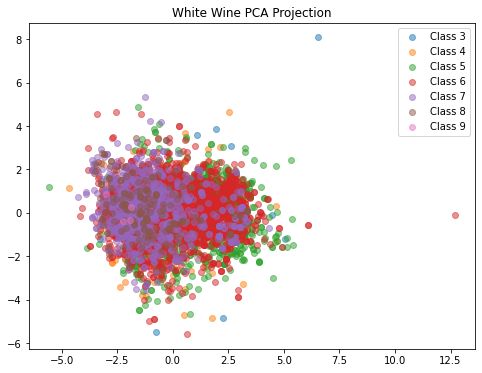

In [15]:
plot_pca(X_white_wine, y_white_wine, "White Wine PCA Projection")

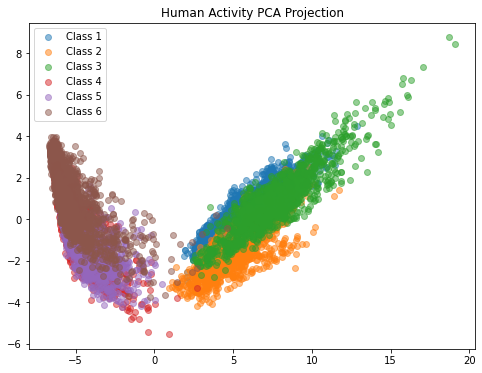

In [16]:
plot_pca(X_human_activity, y_human_activity, "Human Activity PCA Projection")